In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from seaborn import color_palette

import pandas as pd 
import numpy as np
from dateutil.parser import parse

import bokeh
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure, output_file, show, curdoc
from bokeh.models import Circle,BoxSelectTool, BoxZoomTool, LassoSelectTool,Text,HoverTool,ColumnDataSource, Range1d, Axis

In [33]:
totals_pubs = pd.Series(index=pd.date_range('1950-01-01','2015-12-31',freq='AS',),data=[97529,102475,106673,108515,113949,100346,115704,122845,133961,137311,152292,179267,188095,196106,221271,288753,327167,349344,364851,399384,405709,420089,448565,459029,495345,566369,606671,683684,703905,728908,749425,775628,810977,875161,893747,893536,909200,920189,901468,856502,880419,901808,922010,963477,1015818,1080336,1130853,1159929,1161957,1187808,1205276,1189963,1234480,1270516,1356955,1434957,1495934,1567550,1655220,1716898,1750645,1836125,1913473,2005909,2027312,1809485,])
totals_refs = pd.Series(index=pd.date_range('1950-01-01','2015-12-31',freq='AS',),data=[862276,913941,991301,1054144,1082894,993625,1132516,1195067,1291857,1390632,1496650,1927193,2030321,2167335,2530307,3071105,3556047,3822576,4197118,4439659,4483020,4909395,5406217,5614448,5994449,6801509,7391424,7858516,8097995,8733158,9155748,9680861,10507381,11104584,11725145,12482330,12384351,12773481,13165658,13524406,14225948,15057108,15906821,16710320,17930450,19381008,21289915,22082648,22865217,23589060,24585765,25072234,26210739,27773579,29654550,31816766,34430852,36991583,40692695,43594503,46666951,50946087,55088628,59408651,62668029,59436898,])

In [58]:
# df_refs = pd.read_pickle('/Users/jaredlorince/Desktop/d_pop_refs.pkl')
df_pubs = pd.read_pickle('/Users/jaredlorince/Desktop/d_pop.pkl')
#df_keywords = pd.read_pickle('/Users/jaredlorince/Desktop/d_pop_keywords_lem.pkl')

In [4]:
vc = df_keywords.groupby('keyword')['freq'].sum()
vc_df = vc[vc>=100].reset_index()
df_keywords=df_keywords.join(vc_df.set_index('keyword'),on='keyword',how='inner',rsuffix='_')

In [59]:
df_pubs = df_pubs.reset_index().pivot_table(index='date',columns='category',values='uid').fillna(0).resample('AS').sum().ix[:'2015']#.ix['1991':'2015']
#df_refs = df_refs.reset_index().pivot_table(index='date',columns='category',values='cnt').fillna(0).ix['1991':'2015']
#df_keywords = df_keywords.pivot_table(index='date',columns='keyword',values='freq').fillna(0).ix['1991':'2015']

In [6]:
#totals = df.sum(1)
cum_totals_pubs = totals_pubs.cumsum()#.ix['1991':'2015']
cum_totals_refs = totals_refs.cumsum()#.ix['1991':'2015']

In [7]:
total_pubs = totals_pubs#.ix['1991':'2015']

In [8]:
output_notebook()



def update(rawcount=True,cumulative=False,discipline='genomics',data_type='pubs'): #resample='yearly'
    def do_plot():
        df = globals()['df_'+data_type]
        #totals = globals()['totals_'+data_type]
        #totals = totals_pubs
        #cum_totals = globals()['cum_totals_'+data_type]
        #cum_totals = cum_totals_pubs
        lines = {}
        hovers = {}
        data = {}
        colors = ['#%02x%02x%02x' % (a, b, c) for a,b,c in np.round(255*np.array(color_palette("coolwarm",n_colors=len(discipline)))).astype(int)]
        for i,disc in enumerate(discipline):
            current = df[disc]#.resample(resample).sum()
            #totals_current = totals#.resample(resample).sum()

            if cumulative:
                #cum_totals_current = cum_totals#.resample(resample).sum()
                if rawcount:
                    values = current.cumsum()
                else:
                    values = current.cumsum()/cum_totals_pubs.ix['1991':'2015']
            else:
                #totals_current = totals#.resample(resample).sum()
                if rawcount:
                    values = current
                else:
                    values = current/totals_pubs.ix['1991':'2015']
            data[disc] = ColumnDataSource({'x':idx,'value':values,'date':datestrings,'percent':{False:values.apply(lambda x: "{:.2f}%".format(100*x)),True:values.apply(lambda x: "{:,.0f}".format(x))}[rawcount]})
            lines[disc] = p.line('x','value',source=data[disc],color=colors[i],line_width=2)
            hovers[disc] = HoverTool(renderers=[lines[disc]],tooltips=[('Discipline', disc),('date','@date'),('{} this period'.format(data_type),'@percent')])
            p.add_tools(hovers[disc])
            if data_type == 'keywords':
                p.set(x_range=Range1d(parse('1991-01-01'), parse('2016-01-01')))

    if discipline == 'all':
        discpline = df.columns
    else:
        discipline = discipline.strip().split('|')
        
    p = figure(width=800,height=350,x_axis_type='datetime',tools=['pan,box_zoom,reset'])
    p.select(dict(type=Axis, layout="left"))[0].formatter.use_scientific = False
    #resample = {'Daily':'D','Weekly':'W','Monthly':'M','Yearly':'A'}[resample]
    #freq = {'D':'D','W':'W','M':'MS','A':'AS'}[resample]
    idx = pd.date_range('1991-01-01','2015-12-31',freq='AS')
    datestrings = idx.map(lambda x: x.strftime('%Y-%m-%d'))
    if data_type == 'both':
        for data_type in ('pubs','refs'):
            do_plot()#data_type,discipline,p,resample,cumulative,rawcount)
    else:
        do_plot()#data_type,discipline,p,resample,cumulative,rawcount)
    show(p)
    




Loading BokehJS ...

In [9]:
from ipywidgets import Dropdown,Text,Checkbox,interact

disc_select = Text(description='Discipline',value='Psychology')
rawcount_select = Checkbox(description = 'rawcount',value=True)
cumulative_select = Checkbox(description='cumulativ',value=False)
#resample_select = Dropdown(description="Resample",options=["Daily","Weekly","Monthly","Yearly"],value="Yearly")
data_select = Dropdown(description="Data",options=["pubs","refs","keywords","both"],value="keywords")



interact(update,rawcount=rawcount_select,cumulative=cumulative_select,
         disc=disc_select,data_type=data_select); # resample=resample_select,


In [10]:
total_pubs.shape

(25,)

In [11]:
new_df = df_keywords.ix['1991':]
arr_raw = new_df.T.values
arr = new_df.divide(totals_pubs.reindex(new_df.index.values),axis=0).T.values
arr_norm = (arr / arr.max(1,keepdims=True))

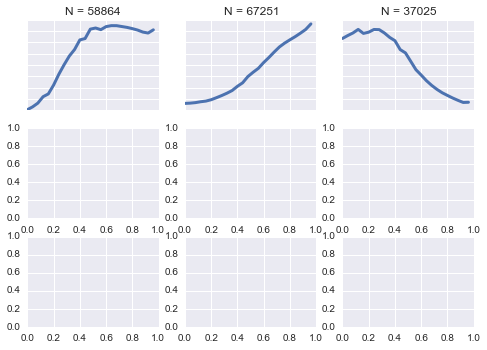

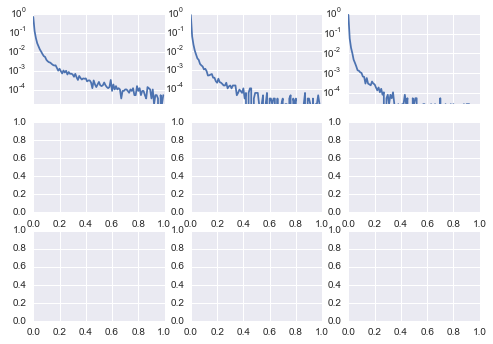

In [25]:
from sklearn.cluster import KMeans
bins = np.linspace(arr_raw.sum(1).min(),arr_raw.sum(1).max(),1000)
for n in (2,3,4,5):
    kmeans = KMeans(n_clusters=n, random_state=0).fit(arr_norm)

    labels = kmeans.labels_
    rows = int(math.ceil(np.sqrt(n)))
    fig,axes = plt.subplots(rows,rows)
    hist_fig,hist_axes = plt.subplots(rows,rows)
    af = axes.flat
    hist_af = hist_axes.flat
    for i,row in enumerate(kmeans.cluster_centers_):
        ax = af.next()
        ax_hist = hist_af.next()
        ax.plot(row,lw=3)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax_hist.set_xticklabels([])
        ax_hist.set_yticklabels([])
        matching = np.where(labels==i)[0]
        ax.set_title('N = {}'.format(len(matching)))
        #rand_sample = np.random.choice(matching,min(500,len(matching)),replace=False)
        vals,_= np.histogram(arr_raw[matching].sum(1),bins=bins)
        ax_hist.plot((vals/float(vals.sum()))[:100])
        #ax_hist.set_xscale('log')
        ax_hist.set_yscale('log')
        ax_hist.set_ylim(0,1)
        #for r in rand_sample:
        #    ax.plot(arr_norm[r],lw=0.01)

In [20]:
for i in xrange(16):
    print i,'|'.join(df_keywords.T.iloc[np.where(labels==i)].sum(1).sort_values(ascending=False).index[:10])
    print '---'

0 oxidative stress|randomized controlled trial|quality of life|mechanical property|obesity|cardiovascular disease|safety|intervention|fabrication|device
---
1 in situ hybridization|cytochrome c|programmed cell death|tumor suppressor gene|map kinase|gene transfer|neutron diffraction|bcl 2|magnetoresistance|t lymphocyte
---
2 ab initio|atomic force microscopy|self assembled monolayers|ab initio calculation|deficient mouse|cutting edge|knockout mouse|mouse lacking|green fluorescent protein|factor kappa b
---
3 management|risk|in vitro|performance|prevalence|risk factor|design|stability|association|simulation
---
4 conversion|physiology|coal|band structure|molecular biology|deoxyribonucleic acid|somatic mutation|chlamydomonas reinhardtii|electrical resistivity|carbon fiber
---
5 impact|health|inflammation|optimization|composite|validation|strategy|efficiency|sensor|metastasis
---
6 of life|balloon angioplasty|dna fragmentation|giant magnetoresistance|taxol|wild type p53|x ray star|retinobl

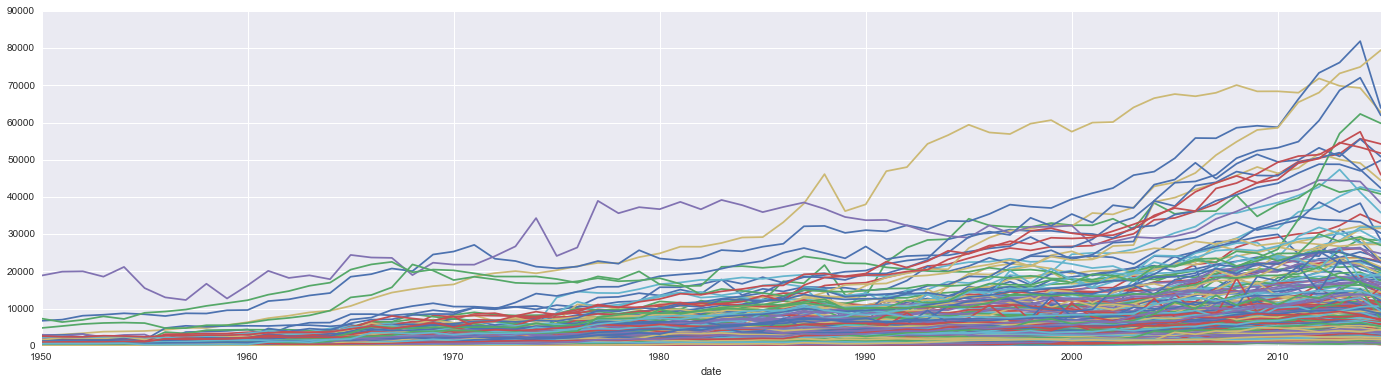

In [49]:
fig,ax = plt.subplots(1,1,figsize=(24,6))
df_pubs.ix[:'2015'].resample('AS').sum().plot(ax=ax,legend=False)

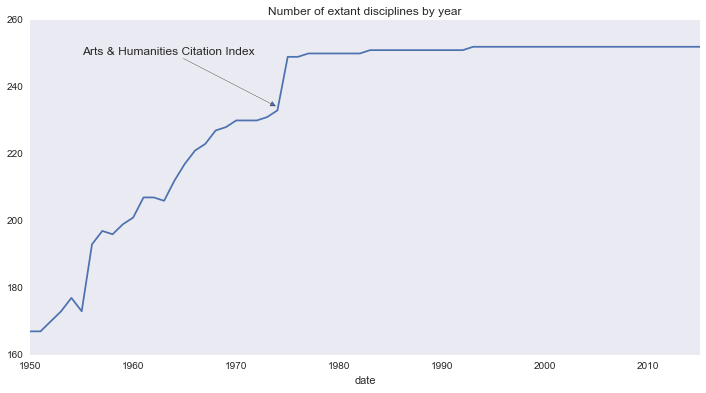

In [124]:
"""
Conference Proceedings Citation Index covers more than 160,000 conference titles in the Sciences starting from 1990 to the present day
Science Citation Index Expanded covers more than 8,500 notable journals encompassing 150 disciplines. Coverage is from the year 1900 to the present day.
Social Sciences Citation Index covers more than 3,000 journals in social science disciplines. Range of coverage is from the year 1900 to the present day.
Arts & Humanities Citation Index covers more than 1,700 arts and humanities journals starting from 1975. In addition, 250 major scientific and social sciences journals are also covered.
"""
fig,ax = plt.subplots(1,1,figsize=(12,6))
(df_pubs>0).sum(1).plot(ax=ax,title='Number of extant disciplines by year')
#ax.arrow('1960', 250, 14, -5, head_width=2, head_length=1, fc='k', ec='k',length_includes_head=True)
ax.annotate("Arts & Humanities Citation Index", xy=('1974', 234), xytext=('1955', 250),
            arrowprops=dict(arrowstyle="-|>"),fontsize=12)
ax.grid()